# classification : 分類問題

# Preparation

## Preparation of google drive (if required)

In [ ]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [ ]:
%cd "ctorch211122/MiniCTorch_Prototype/notebook"

/content/drive/My Drive/Colab Notebooks/ctorch211122/MiniCTorch_Prototype/notebook


## Installation of MiniCTorch

In [1]:
!pip install lark-parser

     |████████████████████████████████| 103 kB 5.4 MB/s 


In [2]:
! pip install git+https://github.com/kojima-r/MiniCTorch_Prototype.git

  Cloning https://github.com/kojima-r/MiniCTorch_Prototype.git to /tmp/pip-req-build-_deuo19j
  Running command git clone -q https://github.com/kojima-r/MiniCTorch_Prototype.git /tmp/pip-req-build-_deuo19j
  Created wheel for minictorch: filename=minictorch-0.0.1-py3-none-any.whl size=16169 sha256=3e36e6dccd002dc383e8e07ab341b690da4df7777e0ea2bece79396cdb5ca005
  Stored in directory: /tmp/pip-ephem-wheel-cache-dye165m8/wheels/1c/0a/b1/3618887a2db533ac9c7b971dc10589e3976893cdf9a74ca6da
Successfully built minictorch


# Target Python Program

In [3]:
import sys
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch
import minictorch.converter as CV

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler

#from torch.utils.data import TensorDataset
#from torch.utils.data import DataLoader

## データ読み込み

In [5]:
# データ読み込み
iris = datasets.load_iris()
data   = iris['data']
target = iris['target']

# 学習データと検証データに分割
x_train, x_valid, y_train, y_valid = train_test_split( data, target, shuffle=True )

# 特徴量の標準化
scaler = StandardScaler()
scaler.fit( x_train )

x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)

# Tensor型に変換
# 学習に入れるときはfloat型 or long型になっている必要があるのここで変換してしまう
x  = torch.from_numpy(x_train).float()
y  = torch.from_numpy(y_train).long()
vx = torch.from_numpy(x_valid).float()
vy = torch.from_numpy(y_valid).long()

print('x_train : ', x_train.shape)
print('y_train : ', y_train.shape)
print('x_valid : ', x_valid.shape)
print('y_valid : ', y_valid.shape)

x_train :  (112, 4)
y_train :  (112,)
x_valid :  (38, 4)
y_valid :  (38,)


## ニューラルネットワークの定義

In [6]:
class Model(torch.nn.Module):

  class Net( torch.nn.Module ):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 64)
        #self.drop1 = nn.Dropout(0.5) ### drop
        self.fc2 = nn.Linear(64, 3)
    
    def forward(self, x):
        self.x1 = F.relu(self.fc1(x))
        #self.x2 = self.drop1(self.x1)  ## drop
        #x = self.fc2(self.x2)
        x = self.fc2(self.x1)
        return x

  class Loss( torch.nn.Module ):
    def __init__( self ):
      super().__init__()
      print("create loss class")

    def forward(self,y,t):
      loss = nn.CrossEntropyLoss()
      #loss = nn.NLLLoss()
      output = loss( y, t )
      return output

  def __init__( self, t ):
    super( Model, self ).__init__()
    print("create model class")
    self.net  = self.Net()
    self.loss = self.Loss()
    self.target = t

  def forward( self, x ):
    self.out = self.net( x )
    out = self.loss( self.out, self.target )
    return out

## プロジェクト名、作業フォルダ、JSONファイル名の設定

In [7]:
project = 'clas'
folder = './classification'
json_path = folder + '/' + project +'.json'

In [8]:
! mkdir -p classification

## 計算グラフをJSONファイルに出力する

In [9]:
def generate_json( json_path, input, target ):

    model = Model( target )
    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        minictorch.trace( model, input, json_path )

    return model

In [11]:
torch.manual_seed( 1 )


batch_size = 16
print(x.shape)
print(y.shape)
inputs = x[0:batch_size,:]
labels = y[0:batch_size]
inputs.requires_grad = True

model = generate_json( json_path, inputs, labels )

torch.Size([112, 4])
torch.Size([112])
create model class
create loss class
[SAVE] ./classification/clas.json
skip: Model/Net[net]/Linear[fc1]/weight/fc1
skip: Model/Net[net]/Linear[fc1]/weight/fc1
skip: Model/Net[net]/Linear[fc2]/weight/fc2
skip: Model/Net[net]/Linear[fc2]/weight/fc2


一回の順伝播、逆伝播のC++コードを生成する

In [ ]:
CV.convert_cpp_code( project, folder, model, inputs, json_path )

[JSON] ./classification/clas.json
{'name': 'Model/Net[net]/Linear[fc1]/weight/weight.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'Model/Net[net]/Linear[fc1]/bias/bias.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'Model/Net[net]/Linear[fc2]/weight/weight', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
{'name': 'Model/Net[net]/Linear[fc2]/bias/bias', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
[PARAM] ./classification/clas_param.cpp
{'name': 'input/x', 'op': 'IO Node', 'in': [], 'output_id': 0, 'shape': [16, 4], 'out': [3], 'sorted_id': 0}
{'name': 'Model/Net[net]/Linear[fc1]/weight/weight.5', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
Model/Net[net]/Linear[fc1]/weight/weight.5  ->  fc1_weight
{'name': 'Model/Net[net]/Linear[fc1]/bias/bia

In [ ]:
#check code
with torch.set_grad_enabled(True):

  output = model( inputs )
  print("output",output)

  model.zero_grad()
  output.backward()
  print("output grad",output.grad)
  print("input grad",inputs.grad)

  # ラベルを予測
  preds = torch.argmax( model.out, dim=1 )

  # イテレーション結果の計算
  epoch_loss = output * inputs.size(0)

  # 正解数の合計を更新
  epoch_corrects = torch.sum( preds == labels.data )

  epoch_loss = epoch_loss / float(inputs.size(0))
  epoch_acc  = epoch_corrects.double() / float(inputs.size(0))

  epoch=1
  print('Train Loss {}: {:.4f} Acc: {:.4f}'.format( epoch, epoch_loss, epoch_acc ))

output tensor(1.1961, grad_fn=<NllLossBackward0>)
output grad None
input grad tensor([[ 6.2436e-03,  4.8876e-03, -2.3265e-03,  2.9070e-03],
        [-1.2798e-02, -2.5030e-04,  4.4503e-03,  1.6768e-03],
        [ 9.7496e-03,  5.7036e-03, -5.2685e-03,  4.4182e-03],
        [ 1.4528e-04, -4.7374e-03, -2.1498e-03, -1.1208e-02],
        [-2.4515e-03,  5.6327e-03,  3.9082e-03,  3.6031e-03],
        [-9.1145e-03, -3.1757e-03,  2.8424e-03, -3.2149e-03],
        [ 3.7645e-03,  6.6292e-03, -1.0205e-03,  5.1491e-03],
        [ 8.8026e-04,  5.9091e-03,  5.8679e-03,  8.5044e-05],
        [-1.1980e-02,  5.4190e-03,  5.8127e-03,  3.1526e-03],
        [ 5.8557e-03,  6.7601e-03, -7.2778e-03,  6.0162e-03],
        [-8.5564e-03, -3.6279e-03,  2.8031e-03, -3.4342e-03],
        [-9.2053e-03, -3.2703e-03,  2.9325e-03, -3.2590e-03],
        [-7.5586e-03, -3.4062e-03,  2.2999e-03, -3.7037e-03],
        [-3.5299e-03,  4.0618e-03,  7.6541e-03,  4.2142e-03],
        [ 7.4150e-03,  2.2720e-03, -1.7030e-03,  3.082

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


# C++予測コード

## 環境構築
(注意) インストール済みの場合は各自の環境に合わせて変更して下さい。

In [ ]:
! git clone https://github.com/xtensor-stack/xtensor.git
! git clone https://github.com/xtensor-stack/xtensor-blas.git
! git clone https://github.com/xtensor-stack/xtl.git
! git clone https://github.com/nlohmann/json.git


Cloning into 'xtensor'...
remote: Enumerating objects: 20418, done.
remote: Counting objects: 100% (3446/3446), done.
remote: Compressing objects: 100% (510/510), done.
remote: Total 20418 (delta 3000), reused 3190 (delta 2921), pack-reused 16972
Receiving objects: 100% (20418/20418), 10.08 MiB | 20.90 MiB/s, done.
Resolving deltas: 100% (14570/14570), done.
Cloning into 'xtensor-blas'...
remote: Enumerating objects: 3857, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 3857 (delta 83), reused 96 (delta 41), pack-reused 3688
Receiving objects: 100% (3857/3857), 4.13 MiB | 16.00 MiB/s, done.
Resolving deltas: 100% (3155/3155), done.
Cloning into 'xtl'...
remote: Enumerating objects: 2399, done.
remote: Counting objects: 100% (258/258), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 2399 (delta 125), reused 137 (delta 58), pack-reused 2141
Receiving objects: 100% (2399/2399), 722.73 KiB | 6.57 

In [ ]:
! git clone https://github.com/kojima-r/MiniCTorch_Prototype.git

Cloning into 'MiniCTorch_Prototype'...
remote: Enumerating objects: 728, done.
remote: Counting objects: 100% (728/728), done.
remote: Compressing objects: 100% (359/359), done.
remote: Total 728 (delta 499), reused 583 (delta 367), pack-reused 0
Receiving objects: 100% (728/728), 42.78 MiB | 10.74 MiB/s, done.
Resolving deltas: 100% (499/499), done.


# コンパイル

In [ ]:
C_SRC = './classification/clas.cpp ./classification/clas_param.cpp'
C_OPT = '-I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include '
C_OUT = './classification/clas'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC $C_OPT -lcblas -o $C_OUT

SRC = ./classification/clas.cpp ./classification/clas_param.cpp
OPT = -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./classification/clas


In [ ]:
!./classification/clas

### forward computation ...
 1.19611 
### backward computation ...
input_grad{{ 0.006244,  0.004888, -0.002326,  0.002907},
 {-0.012798, -0.00025 ,  0.00445 ,  0.001677},
 { 0.00975 ,  0.005704, -0.005269,  0.004418},
 { 0.000145, -0.004737, -0.00215 , -0.011208},
 {-0.002451,  0.005633,  0.003908,  0.003603},
 {-0.009115, -0.003176,  0.002842, -0.003215},
 { 0.003764,  0.006629, -0.00102 ,  0.005149},
 { 0.00088 ,  0.005909,  0.005868,  0.000085},
 {-0.01198 ,  0.005419,  0.005813,  0.003153},
 { 0.005856,  0.00676 , -0.007278,  0.006016},
 {-0.008556, -0.003628,  0.002803, -0.003434},
 {-0.009205, -0.00327 ,  0.002933, -0.003259},
 {-0.007559, -0.003406,  0.0023  , -0.003704},
 {-0.00353 ,  0.004062,  0.007654,  0.004214},
 { 0.007415,  0.002272, -0.001703,  0.003083},
 {-0.003459, -0.000682, -0.002919, -0.00731 }}


# Python 学習コード

In [ ]:
torch.manual_seed( 1 )

#inputs.requires_grad = True
model = Model( labels )

lr = 0.01
opt = torch.optim.SGD( model.parameters(), lr)

epochs = 200
batch_size = 16

num_train = len(x_train)
n_batch = num_train // batch_size  # 1エポックあたりのバッチ数
print("batch",n_batch,len(x_train),batch_size)

epoch_loss = []
epoch_acc = []
for epoch in range(epochs):
    
    # -- 学習 -- 
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)  # インデックスをシャッフルする

    model.train()   # モデルを訓練モードに設定

    total_loss = 0.0
    total_corrects = 0
    for j in range(n_batch):
        
        # ミニバッチを取り出す
        mb_index = index_random[ j*batch_size : (j+1)*batch_size ]
        inputs = x[mb_index, :]
        labels = y[mb_index]
       
        # 順伝播と逆伝播
        model.target = labels
        loss = model( inputs )
        total_loss += loss;

        # 正解数の合計を更新
        #_, preds = torch.max( model.out, 1 )
        preds = torch.argmax( model.out, dim=1 )
        num = torch.sum( preds == labels )
        total_corrects += num

        opt.zero_grad()
        loss.backward()
        opt.step()

    total_acc  = total_corrects.double() / float(num_train)
    print('Train Loss {}: {:.4f} Acc: {:.4f} {}'.format( epoch, total_loss, total_acc, total_corrects ))

    epoch_loss.append( total_loss )
    epoch_acc.append( total_acc )

create model class
create loss class
batch 7 112 16
Train Loss 0: 7.6826 Acc: 0.1339 15
Train Loss 1: 6.6867 Acc: 0.4821 54
Train Loss 2: 5.9344 Acc: 0.6875 77
Train Loss 3: 5.3890 Acc: 0.6875 77
Train Loss 4: 4.9759 Acc: 0.7054 79
Train Loss 5: 4.6521 Acc: 0.7143 80
Train Loss 6: 4.3965 Acc: 0.7143 80
Train Loss 7: 4.1867 Acc: 0.7232 81
Train Loss 8: 4.0195 Acc: 0.7321 82
Train Loss 9: 3.8602 Acc: 0.7589 85
Train Loss 10: 3.7348 Acc: 0.7589 85
Train Loss 11: 3.6161 Acc: 0.7589 85
Train Loss 12: 3.5112 Acc: 0.7946 89
Train Loss 13: 3.4156 Acc: 0.8036 90
Train Loss 14: 3.3346 Acc: 0.8125 91
Train Loss 15: 3.2569 Acc: 0.8214 92
Train Loss 16: 3.1814 Acc: 0.8304 93
Train Loss 17: 3.1155 Acc: 0.8393 94
Train Loss 18: 3.0509 Acc: 0.8571 96
Train Loss 19: 2.9957 Acc: 0.8482 95
Train Loss 20: 2.9394 Acc: 0.8482 95
Train Loss 21: 2.8926 Acc: 0.8482 95
Train Loss 22: 2.8419 Acc: 0.8482 95
Train Loss 23: 2.7959 Acc: 0.8482 95
Train Loss 24: 2.7540 Acc: 0.8571 96
Train Loss 25: 2.7113 Acc: 0.8482

収束状況グラフを描画する

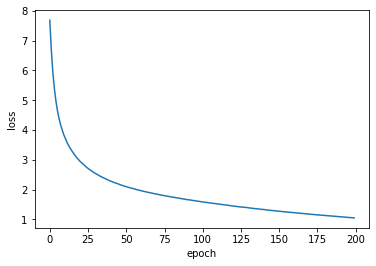

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

正解率を描画する

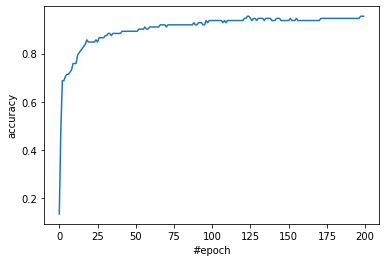

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_acc))),epoch_acc )
ax.set_xlabel('#epoch')
ax.set_ylabel('accuracy')
fig.show()

# C++ 学習コード

## 学習用データファイル、学習ループのC++コードを生成する

In [ ]:
CV.convert_data_file( project, folder, inp_data=x_train, target_data=y_train )
CV.convert_train_code( project, folder, json_path, sol="classification", batch=batch_size, inp_data=x_train, target_data=y_train )

datafile key :  inp_data
datafile key :  target_data
[DATA] ./classification/clas_data.cpp
[JSON] ./classification/clas.json
epoch_num :  200
batch_size :  16
lr :  0.01
inp  shape :  1 {112,4}
target shape :  1 {112}
pred_num :  112
div :  False
pred_pos :  8 8 8
el  0 1  :  input/x IO Node [] 0 -1
el  3 1  :  Model/Net[net]/Linear[fc1]/input.1 aten::linear [0, 1, 2] 0 -1
el  4 1  :  Model/Net[net]/input.3 aten::relu [3] 0 -1
el  7 1  :  Model/Net[net]/Linear[fc2]/input aten::linear [4, 5, 6] 0 -1
el  13 1  :  Model/Loss[loss]/61 aten::cross_entropy_loss [7, 8, 9, 10, 11, 12] 0 -1
 --- pred el ( 0 ) : 7  ->  7
loss pred_id :  13 7
eval no : 13  (type= 2 ) :  7 8
last cmd: 13
------
solution : classification
pred_no   : 7
target_no : 8
class_no  : 8
pred_no :  7
[TRAIN]  ./classification/clas_train.cpp


学習用C++コードをコンパイル、リンクする

In [ ]:
C_SRC = './classification/clas_train.cpp ./classification/clas_param.cpp ./classification/clas.cpp ./classification/clas_data.cpp'
C_OPT = '-I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include '
C_OUT = './classification/clas_train'
!echo "SRC = "$C_SRC
!echo "OPT = "$C_OPT
!echo "OUT = "$C_OUT
!g++ -std=c++14 $C_SRC -D_TRAIN $C_OPT -lcblas -o $C_OUT


SRC = ./classification/clas_train.cpp ./classification/clas_param.cpp ./classification/clas.cpp ./classification/clas_data.cpp
OPT = -I ./MiniCTorch_Prototype/src -I ./xtensor/include -I ./xtensor-blas/include -I ./xtl/include -I ./json/include
OUT = ./classification/clas_train


In [ ]:
! ./classification/clas_train

epoch_num : 200
batch  number  : 7,16
learning ratio : 0.01
total_loss : epoch 0 : loss 7.68434 : Acc 0.133929 15
total_loss : epoch 0 : loss 1.00615 : Acc 0.232143 26
total_loss : epoch 1 : loss 6.67081 : Acc 0.428571 48
total_loss : epoch 1 : loss 0.885935 : Acc 0.651786 73
total_loss : epoch 2 : loss 5.93774 : Acc 0.678571 76
total_loss : epoch 2 : loss 0.798088 : Acc 0.6875 77
total_loss : epoch 3 : loss 5.38456 : Acc 0.705357 79
total_loss : epoch 3 : loss 0.73183 : Acc 0.705357 79
total_loss : epoch 4 : loss 4.97353 : Acc 0.714286 80
total_loss : epoch 4 : loss 0.681222 : Acc 0.714286 80
total_loss : epoch 5 : loss 4.65378 : Acc 0.714286 80
total_loss : epoch 5 : loss 0.641315 : Acc 0.714286 80
total_loss : epoch 6 : loss 4.39808 : Acc 0.714286 80
total_loss : epoch 6 : loss 0.609022 : Acc 0.714286 80
total_loss : epoch 7 : loss 4.18607 : Acc 0.714286 80
total_loss : epoch 7 : loss 0.582233 : Acc 0.732143 82
total_loss : epoch 8 : loss 4.01239 : Acc 0.732143 82
total_loss : epoch

In [ ]:
# read output file from c++ code
path = folder + '/' + project + '.out'
f = open( path, 'r')

loss = []
acc=[]

datalist = f.readlines()
for data in datalist:
  #print(data)
  ds = data.split(',')
  loss.append( float(ds[0]) )
  acc.append( float(ds[1]) )

f.close()

print("epoch =", len(loss))
print( loss )
print(acc)

epoch = 200
[1.006148, 0.885935, 0.798088, 0.73183, 0.681222, 0.641315, 0.609022, 0.582233, 0.559449, 0.539714, 0.522391, 0.506982, 0.493056, 0.480403, 0.468845, 0.458219, 0.448401, 0.439271, 0.430763, 0.422788, 0.415313, 0.408278, 0.401658, 0.3954, 0.38947, 0.38385, 0.378498, 0.373408, 0.368554, 0.363919, 0.359488, 0.355253, 0.351186, 0.347287, 0.343531, 0.339925, 0.336457, 0.333107, 0.329869, 0.326739, 0.323725, 0.320804, 0.317981, 0.315252, 0.312603, 0.310035, 0.307545, 0.305119, 0.302757, 0.300465, 0.298244, 0.296078, 0.293962, 0.291895, 0.289882, 0.287911, 0.285991, 0.284113, 0.282272, 0.280467, 0.2787, 0.276963, 0.275261, 0.273594, 0.271955, 0.270345, 0.268763, 0.267209, 0.265676, 0.264171, 0.262689, 0.261231, 0.259796, 0.258381, 0.256983, 0.255602, 0.254242, 0.252904, 0.251584, 0.25028, 0.248992, 0.247717, 0.246454, 0.245205, 0.243975, 0.242759, 0.241554, 0.240362, 0.239183, 0.238016, 0.23686, 0.235715, 0.23458, 0.233455, 0.232341, 0.231236, 0.230142, 0.229058, 0.227981, 0.22691

収束状況グラフを描画する

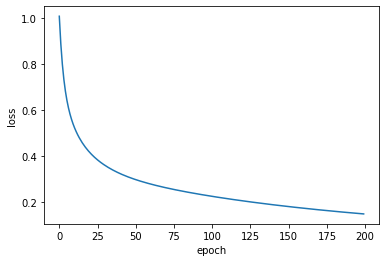

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(loss))), loss)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.show()

正解率を描画する

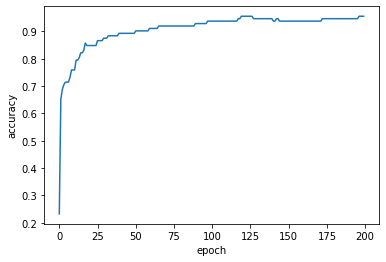

In [ ]:
# 正解率
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(acc))), acc)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
fig.show()